In [33]:
import os
import cv2
import numpy as np
import onnxruntime as ort

from preprocessing import (
    subsample_point_cloud, 
    create_digital_elevation_model,
    pad_multiplo,
    create_input)

from postprocessing import(
    fast_thinning,
    calculate_angle,
    find_distance
)

class PretilNet:
    def __init__(self, weights="model.onnx", providers=('CUDAExecutionProvider',)):
        super().__init__()  # Initialize the parent class
        self.session = ort.InferenceSession(weights, providers=providers)
        self.inputs = self.session.get_inputs()
        self.outputs = self.session.get_outputs()

    def __repr__(self):
        session = self.session
        meta = session.get_modelmeta()
        info = f"{session._model_path} {meta.graph_name} {meta.producer_name}\n"
        info += "Inputs:\n"
        for input_node in session.get_inputs():
            info += f"{input_node.name} {input_node.shape} {input_node.type}\n"
        info += "Outputs:\n"
        for output_node in session.get_outputs():
            info += f"{output_node.name} {output_node.shape} {output_node.type}\n"
        return info

    def __call__(self, las_file, factor_size=0.1):

        ## Preprocessing
        dem_info = self.__preprocessing(las_file, factor_size)
        input = create_input(dem_info['dem']).astype(np.float32)

        ## IA
        inputs_dic = {self.inputs[0].name: input}  # If not a dictionary, create one.
        outputs = self.session.run(None, inputs_dic)  # Returns a list of tensors.

        ## Posprocessing
        return self.__postprocessing(outputs, dem_info['mask'])

    
    def __preprocessing(self, input_file, factor_size):
        las = subsample_point_cloud(input_file, factor=factor_size)
        dem_info = create_digital_elevation_model(las.x,las.y,las.z) # cambiar ahora es un dict dem_info
        dem_info['dem'], dem_info['mask'] = pad_multiplo(dem_info['dem'], dem_info['mask'])
        return dem_info

    def __postprocessing(self, outputs, mask):
        segments = []
        results = []

        mask = np.expand_dims(mask, -1)
        outputs = [o[0,:,:,:].transpose(1, 2, 0) * mask for o in outputs]
        
        img_class = outputs[0]
        img_pretil = outputs[1]

        img_green = img_class[:, :, 1]
        img_red = img_class[:, :, 2]
        img_blue = img_class[:, :, 0]

        green_mask = (img_green > img_red) & (img_green > img_blue)
        binary_img = np.uint8(green_mask) * 255

        # Mejorar máscara
        binary_img = cv2.medianBlur(binary_img, 3)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
        binary_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel, iterations=2)
        binary_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel, iterations=1)

        # Conectividad
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_img, 8)
        valid_components = [i for i in range(1, num_labels) if stats[i, cv2.CC_STAT_AREA] > 150]

        binary_mask = binary_img.astype(bool)
        visualization_img = np.zeros((binary_img.shape[0], binary_img.shape[1], 3), dtype=np.uint8)

        # Parámetros para detección de cambios de dirección
        ANGLE_THRESHOLD = 30  # Umbral en grados para considerar cambio drástico
        MIN_SEGMENT_LENGTH = 20  # Longitud mínima de un segmento
        WINDOW_SIZE = 10  # Tamaño de la ventana para análisis
        STEP_SIZE = 5  # Paso para el análisis de ventanas

        for component in valid_components:
            mask = (labels == component).astype(np.uint8)
            skeleton = fast_thinning(mask)
            
            # Obtener puntos ordenados del esqueleto
            contours, _ = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            visualization_img[mask.astype(bool)] = [128, 128, 128]
            
            for contour in contours:
                contour = contour.reshape(-1, 2)
                num_points = contour.shape[0]
                if num_points < WINDOW_SIZE:
                    continue
                
                current_segment = []
                prev_direction = None
                
                # Procesar ventanas deslizantes
                for i in range(0, num_points - WINDOW_SIZE + 1, STEP_SIZE):
                    window = contour[i:i+WINDOW_SIZE]
                    x_win = window[:, 0]
                    y_win = window[:, 1]
                    
                    # Regresión lineal
                    try:
                        coeffs = np.polyfit(x_win, y_win, 1)
                        m = coeffs[0]
                        dx, dy = 1, m
                        length = np.hypot(dx, dy)
                        current_direction = (dx/length, dy/length)
                    except:
                        # Fallback a puntos extremos
                        dx = x_win[-1] - x_win[0]
                        dy = y_win[-1] - y_win[0]
                        length = np.hypot(dx, dy)
                        if length == 0:
                            continue
                        current_direction = (dx/length, dy/length)
                    
                    # Si es el primer punto del segmento
                    if not current_segment:
                        current_segment.extend(window.tolist())
                        prev_direction = current_direction
                        continue
                    
                    # Calcular ángulo entre direcciones
                    angle = calculate_angle(prev_direction, current_direction)
                    
                    # Si el ángulo es menor que el umbral, continuamos el segmento actual
                    if angle < ANGLE_THRESHOLD:
                        current_segment.extend(window[STEP_SIZE:].tolist())  # Evitar duplicados
                        prev_direction = current_direction  # Actualizamos con la última dirección
                    else:
                        # Si el segmento actual es suficientemente largo, lo guardamos
                        if len(current_segment) >= MIN_SEGMENT_LENGTH:
                            segments.append(np.array(current_segment))
                        # Iniciamos nuevo segmento
                        current_segment = window.tolist()
                        prev_direction = current_direction
                
                # Añadir el último segmento si es válido
                if len(current_segment) >= MIN_SEGMENT_LENGTH:
                    segments.append(np.array(current_segment))

        # Procesar cada segmento por separado
        for segment_idx, segment in enumerate(segments):
            num_points = segment.shape[0]
            
            # Procesar puntos en el segmento con ventanas deslizantes
            for i in range(0, num_points - WINDOW_SIZE + 1, STEP_SIZE):
                window = segment[i:i+WINDOW_SIZE]
                x_win = window[:, 0]
                y_win = window[:, 1]
                
                # Regresión lineal para dirección
                try:
                    coeffs = np.polyfit(x_win, y_win, 1)
                    m = coeffs[0]
                    dx, dy = 1, m
                    length = np.hypot(dx, dy)
                    dir_x, dir_y = dx/length, dy/length
                except:
                    # Fallback a puntos extremos
                    dx = x_win[-1] - x_win[0]
                    dy = y_win[-1] - y_win[0]
                    length = np.hypot(dx, dy)
                    if length == 0:
                        continue
                    dir_x, dir_y = dx/length, dy/length
                
                # Direcciones perpendiculares
                perp_up = (-dir_y, dir_x)
                perp_down = (dir_y, -dir_x)
                
                # Punto medio de la ventana
                mid_idx = i + WINDOW_SIZE // 2
                x0, y0 = segment[mid_idx]
                
                # Calcular distancias
                d_up = find_distance(x0, y0, perp_up, binary_mask)
                d_down = find_distance(x0, y0, perp_down, binary_mask)
                width = (d_up + d_down) * 0.25
                
                # Dibujar línea de medición
                start_x = int(x0 - perp_up[0] * d_down)
                start_y = int(y0 - perp_up[1] * d_down)
                end_x = int(x0 + perp_up[0] * d_up)
                end_y = int(y0 + perp_up[1] * d_up)
                
                cv2.line(visualization_img, (start_x, start_y), (end_x, end_y), (0,0,255), 1)
                cv2.circle(visualization_img, (x0, y0), 2, (0,255,0), -1)
                
                # Obtener altura del pretil
                height = img_pretil[y0, x0]
                results.append((x0, y0, segment_idx, width, height))

        return results




In [34]:
import numpy as np

# Initialize the PretilNet model
model = PretilNet(weights="unet_dynamic.onnx")

path_las = '../data/reduced_Inspecciones_Aéreas_Cámara_L2_Lidar_1.las'

outputs = model(path_las)
print(outputs)

/home/yeriel/workspace/pretiles/env/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:118: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(
2025-03-31 15:34:09.387377785 [W:onnxruntime:, graph.cc:4401 CleanUnusedInitializersAndNodeArgs] Removing initializer 'val_147'. It is not used by any node and should be removed from the model.
2025-03-31 15:34:09.387393347 [W:onnxruntime:, graph.cc:4401 CleanUnusedInitializersAndNodeArgs] Removing initializer 'val_144'. It is not used by any node and should be removed from the model.
2025-03-31 15:34:09.387396260 [W:onnxruntime:, graph.cc:4401 CleanUnusedInitializersAndNodeArgs] Removing initializer 'val_138'. It is not used by any node and should be removed from the model.
2025-03-31 15:34:09.387398507 [W:onnxruntime:, graph.cc:4401 CleanUnusedInitializersAndNodeArgs] Removing initializer '

[(np.int64(384), np.int64(700), 0, 0.75, array([-5.10034072e-13])), (np.int64(379), np.int64(705), 0, 0.75, array([-2.01248167e-12])), (np.int64(374), np.int64(710), 0, 0.75, array([-5.07667639e-13])), (np.int64(369), np.int64(715), 0, 0.75, array([-2.01243049e-12])), (np.int64(372), np.int64(712), 0, 0.75, array([-5.08674526e-13])), (np.int64(377), np.int64(707), 0, 0.75, array([-2.01196034e-12])), (np.int64(382), np.int64(702), 0, 0.75, array([-5.08384631e-13])), (np.int64(1030), np.int64(940), 1, 0.75, array([-0.5359545])), (np.int64(1025), np.int64(945), 1, 0.75, array([-2.21866832])), (np.int64(1020), np.int64(950), 1, 0.75, array([-0.47358152])), (np.int64(1015), np.int64(955), 1, 0.75, array([-2.0264662])), (np.int64(1010), np.int64(960), 1, 0.75, array([-0.42713664])), (np.int64(1005), np.int64(965), 1, 0.75, array([-1.82595774])), (np.int64(1004), np.int64(966), 1, 0.75, array([-0.41240644])), (np.int64(1009), np.int64(961), 1, 0.75, array([-1.85179118])), (np.int64(1014), np.

(1984, 1472, 3) (1984, 1472, 1)


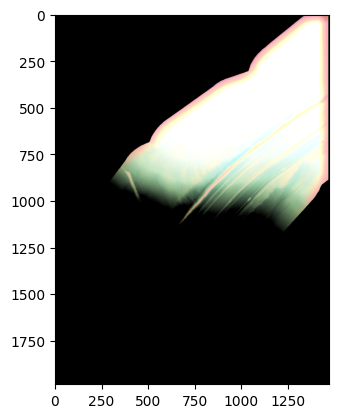

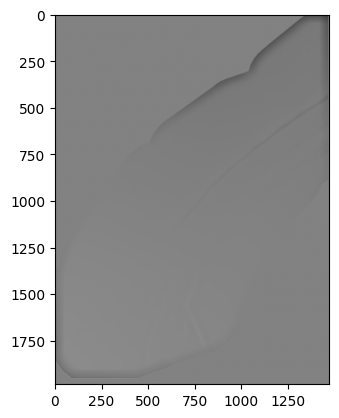

TypeError: list indices must be integers or slices, not str

In [32]:
import matplotlib.pyplot as plt

o1 = outputs[0] 
o1 = (np.clip(o1,0,1) * 255).astype(np.uint8)
o2 = outputs[1]
print(o1.shape, o2.shape)

plt.imshow(o1) 
plt.show()
plt.imshow(o2, cmap='gray') 
plt.show()
outputs['dem'].shape